In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses
import os, random, numpy as np, tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

SEED = 42
os.environ["PYTHONHASHSEED"]=str(SEED)
os.environ["TF_DETERMINISTIC_OPS"]="1"
os.environ["TF_CUDNN_DETERMINISTIC"]="1"
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [3]:
CSV_PATH = './../data/AAPL_1h.csv'
DATE_COL = 'Datetime'

SEQ_LENGTH = 90
BATCH_SIZE = 32
LEARNING_RATE = 0.000001
EPOCHS = 100
TEST_RATIO = 0.01
VAL_SPLIT = 0.1
CANDLES_INTO_FUTURE = 1

FEATURES = [
    # Price and Volume Data (Best with Standard Scaling)
    ('Close', 'standard'),
    ('High', 'standard'),
    ('Low', 'standard'),
    ('Open', 'standard'),
    ('Volume', 'standard'),
    ('log_returns', 'standard'),

    # Momentum, Trend & Volatility Indicators (Best with Standard Scaling)
    ('macd', 'standard'),
    ('roc', 'standard'),
    ('adx', 'standard'),
    ('di_plus', 'standard'),
    ('di_minus', 'standard'),
    ('atr_14', 'standard'),
    ('atr_20', 'standard'),
    ('atr_5', 'standard'),
    ('volume_zscore_50', 'standard'),
    
    # Moving Averages & Bands (Best with Standard Scaling)
    ('ema_10', 'standard'),
    ('ema_20', 'standard'),
    ('ema_50', 'standard'),
    ('ema_100', 'standard'),
    ('ema_200', 'standard'),
    ('bb_lower_20', 'standard'),
    ('bb_middle_20', 'standard'),
    ('bb_upper_20', 'standard'),
    
    # Indicators that are Bounded or Ratios (Best with MinMax Scaling)
    ('rsi_14', 'minmax'),
    ('rsi_28', 'minmax'),
    ('rsi_50', 'minmax'),
    ('rsi_7', 'minmax'),
    ('stoch_k', 'minmax'),
    ('stoch_d', 'minmax'),
    ('close_pos', 'minmax'),         # Position of close within the bar
    ('body_range_ratio', 'minmax'),  # Candle body size vs. total range
    ('bb_width_20', 'minmax'),       # Bounded ratio: BB width as a fraction
    
    # Others
    ('obv', 'standard'),
    ('rolling_max_20', 'standard'),
    ('rolling_min_20', 'standard'),
    ('price_from_20d_high', 'standard'),
]

TARGET = 'Close'



In [4]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer

STANDARD_FEATURES = [name for name, scaling in FEATURES if scaling == 'standard']
MINMAX_FEATURES = [name for name, scaling in FEATURES if scaling == 'minmax']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), STANDARD_FEATURES), 
        ('minmax_scale', MinMaxScaler(), MINMAX_FEATURES)
    ]
)
target_scaler = StandardScaler()
# target_scaler = MinMaxScaler()
N_FEATURES = len(STANDARD_FEATURES) + len(MINMAX_FEATURES)

In [6]:
train_ratio = 1 - TEST_RATIO
train_size = int(df.shape[0] * train_ratio)

X_raw = df[STANDARD_FEATURES + MINMAX_FEATURES]
y_raw = df[TARGET].values

preprocessor.fit(X_raw[:train_size])
X_scaled = preprocessor.transform(X_raw)
X_scaled = pd.DataFrame(X_scaled, columns=STANDARD_FEATURES + MINMAX_FEATURES)

target_scaler.fit(y_raw[:train_size].reshape(-1, 1))
y_scaled = target_scaler.transform(y_raw.reshape(-1, 1)).flatten()


print("X scaled:")
print(tb.tabulate(X_scaled.describe(), headers='keys', tablefmt='psql'))

print("y scaled:")
print(tb.tabulate(pd.DataFrame(y_scaled).describe(), headers='keys', tablefmt='psql'))

X scaled:
+-------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------------+-------------+--------------+--------------+--------------+--------------+---------------+----------------+---------------+--------------+------------------+------------------+-----------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------------+---------------+
|       |        Close |         High |          Low |         Open |       Volume |   log_returns |          macd |           roc |           adx |       di_plus |      di_minus |        atr_14 |        atr_20 |         atr_5 |   volume_zscore_50 |      ema_10 |       ema_20 |       ema_50 |      ema_100 |      ema_200 |   bb_lower_20 |   bb_middle_20 |   bb_upper_20 |          obv |   rolling_max_20 

In [7]:
def create_sequences(X, y, seq_length=SEQ_LENGTH, into_future=CANDLES_INTO_FUTURE):
    sequences = []
    targets = []
    
    for i in range(len(X) - seq_length - into_future + 1):
        seq_x = X[i:i + seq_length]
        seq_y = y[i + seq_length + into_future - 1]
        sequences.append(seq_x)
        targets.append(seq_y)
    
    return np.array(sequences), np.array(targets)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=TEST_RATIO, random_state=SEED, shuffle=False)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3165, 90, 36)
y_train shape: (3165,)
X_test shape: (32, 90, 36)
y_test shape: (32,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(units=128, 
         return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False), 
    Dropout(0.3),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

d:\PrivateProjects\WhiteRock\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 128)        │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,001 (531.25 KB)

 Trainable params: 136,001 (531.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1), 
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
]

history = model.fit(
    X_train, y_train,
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.1335 - val_loss: 0.5837 - learning_rate: 0.0010
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.1479 - val_loss: 1.1838 - learning_rate: 0.0010
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.1655 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.1306 - val_loss: 0.6442 - learning_rate: 0.0010
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.1257 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.1223 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0961 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.1125 - val_loss: 0.3838 - learning_rate: 0.0010
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.1081 - val_loss: 0.4937 - learning_rate: 0.0010
Epoch 10/1

In [10]:
SAVE_PATH = f'./../models/m2/into_{CANDLES_INTO_FUTURE}/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
model.save(SAVE_PATH + 'lstm_model.h5')
joblib.dump(preprocessor, SAVE_PATH + 'preprocessor.save')
joblib.dump(target_scaler, SAVE_PATH + 'target_scaler.save')
print(f"Model and scalers saved to {SAVE_PATH}")

Model and scalers saved to ./../models/m2/into_1/


In [11]:
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R2:", r2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Test MSE: 193.29309465191903
Test MAE: 13.73948574066162
Test R2: -31.01363326819238


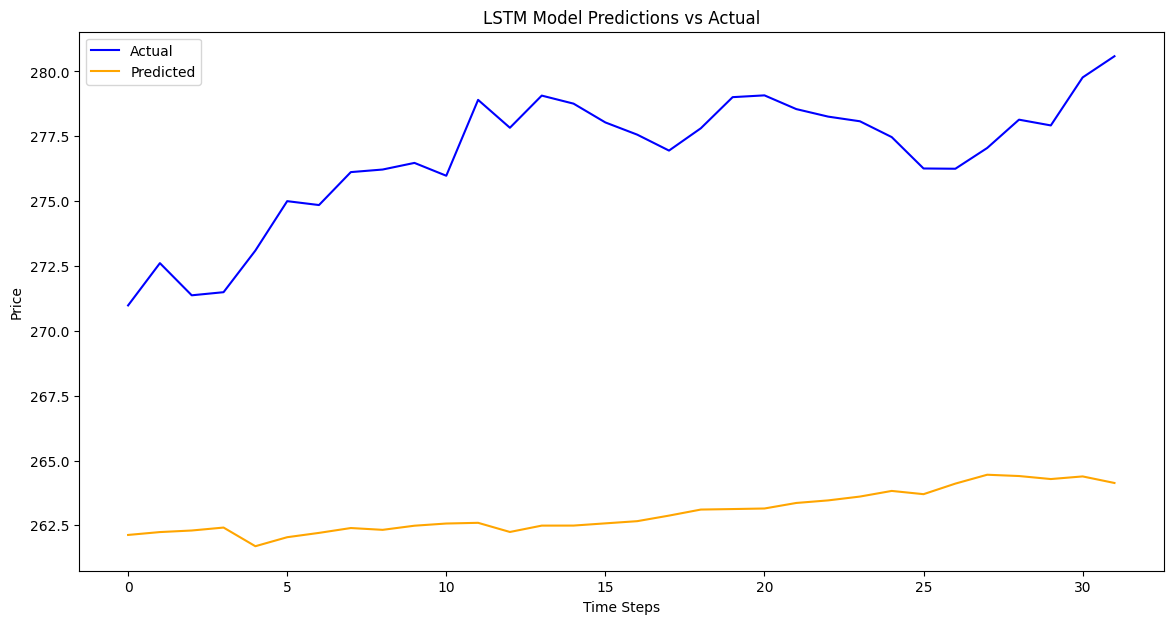

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()